In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
from pathlib import Path

### Завантаження даних (Load data)

In [2]:
current_path = Path().absolute()
pickle_models_path = Path(current_path.parent.parent.parent, "lib", "models")
resources_data_path = Path(current_path.parent, "resources", "data")

In [3]:
#load features
tabular_data = pd.read_csv(Path(resources_data_path, "tabular_data.csv"))
tabular_data.head()

,id,period,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,0,1,110.0,55.0,0.432017,0.000000,176.78,0.0,0.323712,NaN,...,0.00,0,0.000000,0.0,55.0,2.0,0.526552,145.0,133.28,0.0
1,0,2,110.0,110.0,0.397517,0.000000,315.42,0.0,0.316798,NaN,...,0.00,0,0.000000,0.0,110.0,1.0,0.481063,130.0,229.97,0.0
2,0,3,110.0,55.0,0.359440,0.000000,354.55,0.0,0.339188,NaN,...,0.07,0,0.000000,0.0,55.0,1.0,0.509598,180.0,231.78,0.0
3,0,4,110.0,55.0,0.285707,0.000000,229.98,0.0,0.415428,NaN,...,0.00,0,0.000000,0.0,55.0,0.0,0.680089,142.0,183.83,0.0
4,0,5,110.0,55.0,0.101487,444.730391,307.12,0.0,0.569670,NaN,...,0.95,0,20.014485,0.0,55.0,0.0,0.776175,85.0,155.83,0.0


In [4]:
# List of id columns
ids = ['id', 'period']

In [5]:
#load target class data
train = pd.read_csv(Path(resources_data_path, "train.csv"))
print(train.shape)
train.head()

(4084, 2)


,id,target
0,0,0
1,1,0
2,2,1
3,3,0
4,4,1


### Розподіл даних на навчальну та тестову вибірки (Split to train and test data)

In [6]:
# Splits tabular_data by subsets of target data in order to prevent period data splitted

from sklearn.model_selection import train_test_split

print('tabular_data rows with target provided: ', pd.merge(tabular_data, train, how='left', on='id').dropna(subset=['target']).shape[0])

# split target data to train and test subsets
id_train, id_test, target_train, target_test = train_test_split(train.id, train.target, random_state=5)
print(id_train.shape, target_train.shape, target_train.mean())
print(id_test.shape, target_test.shape, target_test.mean())

# pd.merge(tabular_data, id_train, how='left', on='id').drop
tabular_data_train = pd.DataFrame(tabular_data[tabular_data.id.isin(id_train)])
print(tabular_data_train.shape)

tabular_data_test = pd.DataFrame(tabular_data[tabular_data.id.isin(id_test)])
print(tabular_data_test.shape)

tabular_data rows with target provided:  49008
(3063,) (3063,) 0.2615083251714006
(1021,) (1021,) 0.2683643486777669
(36756, 52)
(12252, 52)


### Підготовка даних (очищення та перетворення)

#### Коригування знаку

In [7]:
#sign correction
enable_sign_correction = True
features_to_correct = ['feature_6', 'feature_8', 'feature_11', 'feature_23', 'feature_32', 'feature_34']

if enable_sign_correction:
    for feature in features_to_correct:
        tabular_data_train[feature] = tabular_data_train[feature].abs()

#### Видалення рядків з 10 та більше відсутніх значень

In [8]:
# Delete rows over margin of NaNs count
nans_count_margin = 10

nans_count = tabular_data.isna().aggregate(func=sum, axis=1)

rows_to_delete = nans_count[nans_count >= 10].index
print("Rows to delete:\n", rows_to_delete)
print("Total rows before: ", tabular_data_train.shape[0])
tabular_data_train = tabular_data_train.drop(index=rows_to_delete, errors='ignore')
print("Total rows after: ", tabular_data_train.shape[0])

Rows to delete:
 Int64Index([   39,    40,    41,    42,    43,    44,    45,    46,    47,
              135,
            ...
            60704, 60705, 60706, 60707, 61014, 61015, 61016, 61017, 61018,
            61019],
           dtype='int64', length=1763)
Total rows before:  36756
Total rows after:  35633


#### Кодування категоріальних характеристик

In [9]:
# Encode object features
df_to_encode = tabular_data_train
print('Object features:')
features_to_encode = df_to_encode.dtypes[df_to_encode.dtypes == 'O'].drop(columns=ids).index

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#NaN should be encoded as another value
encoded_data = df_to_encode
for feature in features_to_encode:
    encoded_data[feature] = le.fit_transform(df_to_encode[feature].fillna('__NaN__'))
    print(feature + " has been encoded")
encoded_data = encoded_data.drop(columns=features_to_encode, errors='ignore')   

print('Encoded features: ')
print(features_to_encode)

Object features:
feature_25 has been encoded
Encoded features: 
Index(['feature_25'], dtype='object')


#### Видалення викидів (сплесків)

In [10]:
# Delete splashes
splashes_margin = 0.03
splashed_data = encoded_data

unsplashed_data = splashed_data[splashed_data.columns.drop(['id', 'period'])]
mean_std = pd.DataFrame({'mean':splashed_data.mean(), 
                         'std':splashed_data.std(),
                         'q_left':splashed_data.quantile(q=splashes_margin, interpolation='lower'),
                         'q_right':splashed_data.quantile(q=1-splashes_margin, interpolation='higher'),
                         'q_left_10':splashed_data.quantile(q=0.1, interpolation='lower'),
                         'q_right_10':splashed_data.quantile(q=1-0.1, interpolation='higher')
                         })
mean_std['m_left'] = mean_std['mean'] - 3*mean_std['std']
mean_std['m_right'] = mean_std['mean'] + 3*mean_std['std']

mean_std['mean_10'] = splashed_data[(splashed_data >= mean_std['q_left_10']) & (splashed_data <= mean_std['q_right_10'])].mean() 
mean_std['std_10'] = splashed_data[(splashed_data >= mean_std['q_left_10']) & (splashed_data <= mean_std['q_right_10'])].std() 

mean_std['ms_10_left'] = mean_std['mean_10'] - 3*mean_std['std_10']
mean_std['ms_10_right'] = mean_std['mean_10'] + 3*mean_std['std_10'] 

#cut splashes based on 3*sigma of central 80% values
unsplashed_data = splashed_data[{'id', 'period'}] \
    .join(unsplashed_data[ (unsplashed_data >= mean_std['ms_10_left']) & (unsplashed_data <= mean_std['ms_10_right']) ])
print(unsplashed_data.shape)
# mean_std.head()

<ipython-input-10-189bee18e74e>:24: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  .join(unsplashed_data[ (unsplashed_data >= mean_std['ms_10_left']) & (unsplashed_data <= mean_std['ms_10_right']) ])
<ipython-input-10-189bee18e74e>:24: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  .join(unsplashed_data[ (unsplashed_data >= mean_std['ms_10_left']) & (unsplashed_data <= mean_std['ms_10_right']) ])


(35633, 51)


#### Видалення незначних характеристик

In [11]:
# Delete non-significant features
nonsignifican_margin = 0.05

#TIME CONSUMING! (because of nunique)
#count uniques and check for data types
#NaN is not unique value!
#Look for object - it's categorial, so should be converted to dummies
input_data = unsplashed_data
tabular_data_report = pd.DataFrame({'dtypes':input_data.dtypes,
                                    'nunique':input_data.nunique(), 
                                    'nan_count':input_data.isna().sum(),
                                    'm_left':input_data.quantile(q= nonsignifican_margin, interpolation='lower'),
                                    'm2_left':input_data.quantile(q= 2*nonsignifican_margin, interpolation='lower'),
                                    'm2_right':input_data.quantile(q= 1 - 2*nonsignifican_margin, interpolation='higher'),                                    
                                    'm_right':input_data.quantile(q= 1 - nonsignifican_margin, interpolation='higher'),
                                    '5%':input_data.quantile(q=0.05),
                                    '10%':input_data.quantile(q=0.10),
                                    '90%':input_data.quantile(q=0.90),
                                    '95%':input_data.quantile(q=0.95)
                                   })
tabular_data_report = tabular_data_report.join(input_data.describe().transpose()) \
    .drop(['id', 'period'])
tabular_data_report

nonsignificants = tabular_data_report[ (tabular_data_report['nunique'] <= 1) |
                     (tabular_data_report.m_left == tabular_data_report.m_right) | 
                     (tabular_data_report['min'] == tabular_data_report.m2_right) | 
                     (tabular_data_report.m2_left == tabular_data_report['max']) ]
print("Nonsignificant features:", nonsignificants.index)
# nonsignificants
cleaned_data = input_data.drop(columns=nonsignificants.index, errors='ignore')
cleaned_data.columns

Nonsignificant features: Index(['feature_0', 'feature_5', 'feature_37', 'feature_38', 'feature_39',
       'feature_41'],
      dtype='object')


Index(['id', 'period', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10',
       'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15',
       'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20',
       'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_26',
       'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31',
       'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36',
       'feature_40', 'feature_42', 'feature_43', 'feature_44', 'feature_45',
       'feature_46', 'feature_47', 'feature_48', 'feature_49'],
      dtype='object')

### Навчання спрощеної моделі логістичної регресії (2 характеристики)

In [12]:
#simple model - two most significant non-scaled features 
logit_features_short = ['feature_6', 'feature_46']
logit_train_data = pd.merge(cleaned_data[set(logit_features_short) | {'id'}].dropna(), train, how='left', on='id')

#Балансування - додати копію даних класу 1
logit_train_data_oversampled = logit_train_data.append(logit_train_data[logit_train_data.target == 1])
logit_train_data_oversampled = logit_train_data_oversampled.append(logit_train_data[logit_train_data.target == 1])

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X = logit_train_data_oversampled[logit_features_short]
y = logit_train_data_oversampled.target

logreg_short = LogisticRegression()
logreg_short.fit(X, y)

# вивантаження моделі до зовнішнього файлу
import pickle
path=Path(pickle_models_path, "LogisticRegression_simple_6_46.pkl")

with open(path, 'wb') as file:
    pickle.dump(logreg_short, file)

### Навчання повної моделі логістичної регресії

In [13]:
# початковий перелік характеристик
# logit_features_full = {'feature_2', 'feature_6', 'feature_12', 'feature_15', 'feature_18', 'feature_19', 'feature_23', 'feature_33', 'feature_46'}
# logit_features_full = {'feature_6', 'feature_46'}
# logit_features_full = set(cleaned_data.columns).difference({'id', 'period'})
# logit_features_full = set(['feature_11', 'feature_46', 'feature_48', 'feature_16', 'feature_35',
#        'feature_6', 'feature_40', 'feature_10', 'feature_36', 'feature_47',
#        'feature_12', 'feature_4', 'feature_8', 'feature_43', 'feature_31',
#        'feature_7', 'feature_22', 'feature_18', 'feature_32', 'feature_3'])
logit_features_full = ['feature_46', 'feature_35',
       'feature_6', 'feature_40', 'feature_47',
       'feature_12', 'feature_4', 'feature_31',
       'feature_18', 'feature_32', 'feature_3']

logit_train_data = pd.merge(cleaned_data[set(logit_features_full) | {'id'}].dropna(), train, how='left', on='id')
logit_train_data_oversampled = logit_train_data.append(logit_train_data[logit_train_data.target == 1])
logit_train_data_oversampled = logit_train_data_oversampled.append(logit_train_data[logit_train_data.target == 1])
logit_train_data_oversampled.target.value_counts()

0    11110
1    10626
Name: target, dtype: int64

#### Створення моделі стандартизації та її вивантаження до зовнішнього файлу

In [14]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(logit_train_data[logit_features_full])
X_scaled = pd.DataFrame(scaler.transform(logit_train_data_oversampled[logit_features_full]), 
                        columns=logit_features_full, index=logit_train_data_oversampled.index)

# X = logit_train_data_oversampled[logit_features]
X = X_scaled
y = logit_train_data_oversampled.target

path=Path(pickle_models_path, "Scaler.pkl")

with open(path, 'wb') as file:
    pickle.dump(scaler, file)

print(X.shape)
print(y.shape)
# X_scaled

(21736, 11)
(21736,)


#### Оптимізація переліку характеристик (RFE)

In [15]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg_full = LogisticRegression()

rfe = RFE(logreg_full, n_features_to_select=20)
rfe = rfe.fit(X, y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)
cols = X.columns
cols[rfe.support_]

[ True  True  True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1 1]


Index(['feature_46', 'feature_35', 'feature_6', 'feature_40', 'feature_47',
       'feature_12', 'feature_4', 'feature_31', 'feature_18', 'feature_32',
       'feature_3'],
      dtype='object')

In [16]:
import statsmodels.api as sm


logit_model = sm.Logit(y,X)
result = logit_model.fit()
print(result.summary2())

# оптимізований перелік характеристик (p_value < 0.05) вносимо до logit_features 4 етапи вище

Optimization terminated successfully.
         Current function value: 0.605406
         Iterations 5
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.126     
Dependent Variable: target           AIC:              26340.2280
Date:               2021-06-13 17:11 BIC:              26428.0820
No. Observations:   21736            Log-Likelihood:   -13159.   
Df Model:           10               LL-Null:          -15061.   
Df Residuals:       21725            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
feature_46    0.4079    0.0176   23.2418  0.0000   0.3735   0.4423
feature_35    0.0908    0.0176    5.1685  0.0000   0.0563   0.

#### Створення моделі логістичної регресії за обраним переліком характеристик

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

logreg_full = LogisticRegression()
logreg_full.fit(X, y)

LogisticRegression()

#### Вивантаження моделі до зовнішнього файлу

In [18]:
import pickle
path=Path(pickle_models_path, "LogisticRegression_scaled_full.pkl")

with open(path, 'wb') as file:
    pickle.dump(logreg_full, file)

### Тестування

#### Опис функції виведення результатів тестування

In [19]:
def print_prediction_report(xy):
    from sklearn.metrics import confusion_matrix
    # confusion_matrix = confusion_matrix(y_test, y_pred)
    # [[t0, f1] 
    #  [f0, t1]]
    confusion_matrix = confusion_matrix(xy.target, xy.y_pred)
    target_value_counts = xy.target.value_counts()
    print(target_value_counts)
    print(confusion_matrix)
    # xy_predicted_data.shape
    print('Overall data to predicted class 1 ratio (selectivity): {:.2f}'. \
          format(xy.shape[0] / (confusion_matrix[1,1] + confusion_matrix[0,1])))
    print('Precision of class 1 prediction (precision): {:.2f}'.format(confusion_matrix[1,1] / (confusion_matrix[1,1] + confusion_matrix[0,1])))
    print('(initial class 1 probability is {:.2f})'.format(target_value_counts[target_value_counts.index == 1].sum() / target_value_counts.sum()))
    print('Completeness of class 1 prediction (recall): {:.2f}'.format(confusion_matrix[1,1] / (confusion_matrix[1,1] + confusion_matrix[1,0])))

    print('mean(target) = {:.3f}'.format(xy.target.mean()))
    print('mean(y_pred) = {:.3f}'.format(xy.y_pred.mean()))
    print('mean(y_pred_proba) = {:.3f}'.format(xy.y_pred_proba.mean()))
    
    from sklearn.metrics import classification_report
    print(classification_report(xy.target, xy.y_pred))
    #показники якості бінарної кваліфікації:
    #recall - повнота (яка частина певного класу виявлена)
    #precision - точність (яка частина припущень щодо належності до класу є вірною)

    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import roc_curve
    logit_roc_auc = roc_auc_score(xy.target, xy.y_pred)
    fpr, tpr, thresholds = roc_curve(xy.target, xy.y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    # plt.savefig('Log_ROC')
    plt.show()

#### Тестування скороченої моделі

In [20]:
logit_test_data = pd.merge(
    tabular_data_test[set(logit_features_short) | {'id'}], train, how='left', on='id').dropna()

In [21]:
X_test = logit_test_data[logit_features_short]
y_pred = logreg_short.predict(X_test)
y_pred_proba = logreg_short.predict_proba(X_test)[:,1]
score = logreg_short.score(X_test, logit_test_data.target)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(score))
logit_test_predicted = logit_test_data.join(pd.DataFrame({'y_pred':y_pred, 'y_pred_proba':y_pred_proba}, index=logit_test_data.index))

# logit_test_predicted

Accuracy of logistic regression classifier on test set: 0.65


0    7547
1    2806
Name: target, dtype: int64
[[4808 2739]
 [ 936 1870]]
Overall data to predicted class 1 ratio (selectivity): 2.25
Precision of class 1 prediction (precision): 0.41
(initial class 1 probability is 0.27)
Completeness of class 1 prediction (recall): 0.67
mean(target) = 0.271
mean(y_pred) = 0.445
mean(y_pred_proba) = 0.469
              precision    recall  f1-score   support

           0       0.84      0.64      0.72      7547
           1       0.41      0.67      0.50      2806

    accuracy                           0.65     10353
   macro avg       0.62      0.65      0.61     10353
weighted avg       0.72      0.65      0.66     10353



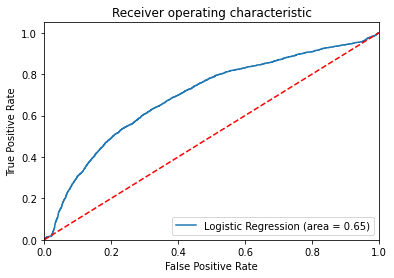

In [22]:
print_prediction_report(pd.DataFrame({
    'target':logit_test_predicted.target, 
    'y_pred':logit_test_predicted.y_pred, 
    'y_pred_proba':logit_test_predicted.y_pred_proba}))

#### Тестування повної моделі

In [23]:
logit_test_data = pd.merge(
    tabular_data_test[set(logit_features_full) | {'id'}], train, how='left', on='id').dropna()

In [24]:
X_test = scaler.transform(logit_test_data[logit_features_full])
y_pred = logreg_full.predict(X_test)
y_pred_proba = logreg_full.predict_proba(X_test)[:,1]
score = logreg_full.score(X_test, logit_test_data.target)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(score))
logit_test_predicted = logit_test_data.join(pd.DataFrame({'y_pred':y_pred, 'y_pred_proba':y_pred_proba}, index=logit_test_data.index))

# logit_test_predicted.head()
# logit_test_predicted[logit_test_predicted.y_pred.isna()]

Accuracy of logistic regression classifier on test set: 0.67


In [25]:
# print_prediction_report(pd.DataFrame({
#     'target':logit_test_predicted.target, 
#     'y_pred':logit_test_predicted.y_pred, 
#     'y_pred_proba':logit_test_predicted.y_pred_proba}))

In [26]:
# агрегація результатів класифікації
logit_test_predicted_agg = logit_test_predicted.groupby('id').mean()
logit_test_predicted_agg['y_pred_agg'] = (logit_test_predicted_agg.y_pred_proba >= 0.5).mul(1)
# logit_test_predicted_agg[{'target', 'y_pred_proba', 'y_pred_agg'}].head()

0.0    591
1.0    208
Name: target, dtype: int64
[[440 151]
 [ 85 123]]
Overall data to predicted class 1 ratio (selectivity): 2.92
Precision of class 1 prediction (precision): 0.45
(initial class 1 probability is 0.26)
Completeness of class 1 prediction (recall): 0.59
mean(target) = 0.260
mean(y_pred) = 0.343
mean(y_pred_proba) = 0.415
              precision    recall  f1-score   support

         0.0       0.84      0.74      0.79       591
         1.0       0.45      0.59      0.51       208

    accuracy                           0.70       799
   macro avg       0.64      0.67      0.65       799
weighted avg       0.74      0.70      0.72       799



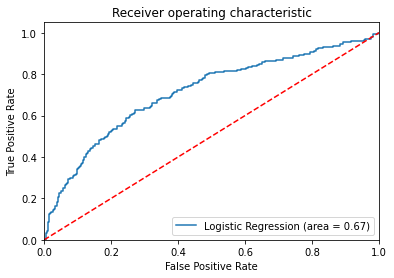

In [27]:
print_prediction_report(pd.DataFrame({
    'target':logit_test_predicted_agg.target, 
    'y_pred':logit_test_predicted_agg.y_pred_agg, 
    'y_pred_proba':logit_test_predicted_agg.y_pred_proba}))

### Збереження варіантів тестових підвибірок до JSON-файлів

In [28]:
# prepare data for API tests
api_test_data = pd.merge(tabular_data_test, train, how='left', on='id').dropna(subset=logit_features_full)

# повна тестова вибірка
api_test_data_full = api_test_data
api_test_data_full.to_json(Path(resources_data_path, "api_test_data_full.json"))

# перші 25% тестової вибірки
api_test_data_1000 = api_test_data[api_test_data.id < 1000]
# .drop(columns=['target'])
api_test_data_1000.to_json(Path(resources_data_path, "api_test_data_1000.json"))

# без водіїв
api_test_data_no_drivers = api_test_data[api_test_data.target == 0]
# .drop(columns=['target'])
api_test_data_no_drivers.to_json(Path(resources_data_path, "api_test_data_no_drivers.json"))

# тільки водії
api_test_data_drivers = api_test_data[api_test_data.target == 1]
# .drop(columns=['target'])
api_test_data_drivers.to_json(Path(resources_data_path, "api_test_data_drivers.json"))